## Домашнее здание №2 / Link Prediction

### Фамилия Имя / Группа

----
План выполнения домашнего задания:

1. Краткий обзор исходных данных
2. Генерация дополнительных данных
3. Создание матрицы признаков для ребер
4. Настройка модели и валидация качества модели
5. Отправка результатов в контест на Kaggle

----

В данном домашнем задании вам предстоит построить классификатор, который бы предсказывал наличие или отсутствия ребра в графе между двумя вершинами. Никакой дополнительной информации о вершинах, кроме ее соседей нет, поэтому вам придется создавать вектор признаков для каждой пары вершин на основе топологии графа.

Вершины графа - товары интернет магазина, наличие ребра символизируют о высокой частоте совместной покупки данных товаров вместе. Например если в нашем графе присутствую вершины молоко и хлеб и данные товары часто покупаются вместе, то между данными вершинами будет ребро. Если в нашем графе есть вершины молоко и кроссовки, то между данными вершинами ребра не будет. 

В данном датасете уровень относительной частоты по которому решается есть ребро между вершинами или его нет был определен за нас. Сам датасет был получен краулингом сайта Amazon.com в марте 2003 года, парсилась секция "Люди которые купили данный продукт, также преобретали это..."

Мотивация данного задания: Расширить список блока рекомендаций, за счет товаров которые с высокой вероятность могут оказаться в одной корзине покупателя.

----
Для создания модели и работы с данными мы будем использовать пакет GraphLab, структуры данных SFrame и SGraph идеально подходят для работы с графами. Распределенное хранение данных и применения функций для расчета метрик отдельных вершин сильно облегчают работу с графом.

Библиотека платная, но лицензия для академических целей получается в течении 5 минут, чтобы установить пакет следуйте шагам на сайте - https://turi.com/download/academic.html

----

Описание файлов:

1. the_graph.csv - файл содержащий ребра графа, две колонки: src,dst 
2. suspicions.csv - файл с ребрами, графа. Для данных ребер неизвестно присутствует ли оно в графе или нет.

Описание целевой метрики - в качестве целевой метрики будем использовать ROC AUC http://mlwiki.org/index.php/ROC_Analysis

----

In [1]:
import graphlab as gl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
gl.canvas.set_target('ipynb')

This non-commercial license of GraphLab Create for academic use is assigned to levkov.mn@phystech.edu and will expire on November 08, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1479248168.log


### 1. Краткий обзор исходных данных - 10 Баллов

Загрузим данные, найдем ряд базовых статистик:

1. Количество вершин и ребер
2. Распределение степеней вершин графа (График log - log)
3. Плотность графа
4. Диаметр графа
5. Количество треугольников в графе
6. Краткие выводы о данных.
7. БОНУСЫ - сделайте красивую визулизацию или расчет дополнительных метрик с выводами и вы получите дополнительные баллы за задание

In [5]:
edges = gl.SFrame.read_csv('the_graph.csv', delimiter=',', verbose=False)

In [6]:
g = gl.SGraph().add_edges(edges, src_field='src', dst_field='dst')

1. Количество вершин и ребер

In [7]:
vert_edgs = g.summary()

print 'Number of vertices = {0}'.format(vert_edgs['num_vertices'])
print 'Number of edges = {0}'.format(vert_edgs['num_edges'])

Number of vertices = 262111
Number of edges = 1384871


In [8]:
g_vertices = g.get_vertices().to_numpy()
g_vertices = np.array([g_vertices[i][0] for i in range(len(g_vertices))])

Выполните пункты 2 - 6. В пункте 6 напишите краткие выводы.

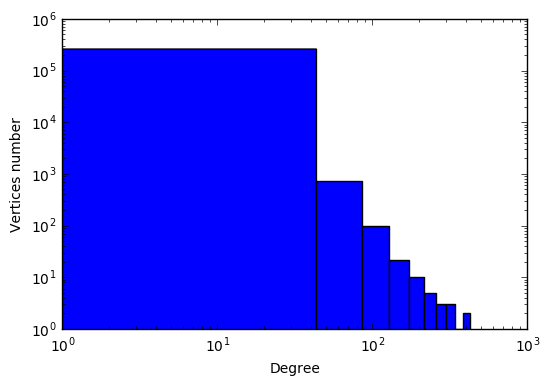

GDensity: 5.28352873401
Triangles number: 717754


In [6]:
deg = sorted(gl.degree_counting.create(g).graph.get_vertices()['total_degree'])
deg.reverse()
plt.hist(deg, log=True)
plt.xlabel('Degree')
plt.ylabel('Vertices number')
plt.xscale('log')
plt.show()

print('GDensity: {}'.format((1. * vert_edgs['num_edges'] / vert_edgs['num_vertices'])))

# graphLab can't compute graph diameter, so lets build graph G in networkx library
import networkx as nx
G = nx.Graph()
G.add_nodes_from(g_vertices)
G.add_edges_from(g.get_edges().to_numpy())
# оч долго, не смогло
#print('Diameter: {}'.format(nx.diameter(G)))

print('Triangles number: {}'.format(gl.triangle_counting.create(g, verbose=False).num_triangles))

----
### 2. Генерация дополнительных данных - 20 Баллов

Перед нами стоит задача создания модели классификации, которая в дальнейшем будет использоваться для повышения разнообразия блока рекомендаций. Для большинства моделей классификации требуется минимум 2 класса объектов - негативный и позитивный. Но у нас есть только граф, ребра которые в нем присутствуют это позитивные примеры. Получается, что у нас нет негативных примеров. 

Ответьте на 3 вопроса:

1. Можем ли мы сами создать негативные примеры? Граф это описание связей между вершинами, если мы будем случайным образом выбирать две вершины и считать, что это ребро - негативный пример, имеет ли это смысл?
2. Если мы решим сгенерировать негативные примеры, как должна быть устроена процедура генерации, чтобы обобщаяющая способность модели была наилучшей?
3. Как зависит обобщающая способность модели от негативных примеров, которые мы ей покажем?

------
Создадим класс отрицательных примеров, сгенерировав его самым простым образом: берем две вершины, если ребро между ними отсутствует в графе, то это отрицательный пример.

1. Попробуйте улучшить генерацию отрицательных примеров

In [9]:
# read in existing edges
graph_file = open('the_graph.csv')
graph_file.readline() # first line is column names
existing_edges = set()

for x in graph_file:
    start, end = x.split(',')
    start, end = int(start), int(end)
    existing_edges.add((start, end))
    
print len(existing_edges)

1384871


Попробуем улучшить генерацию отрицательных примеров следующим способом: хочется добавлять в generated_nonexisting_edges ребра, у которых большие степени вершин.

In [8]:
deg_counter = gl.degree_counting.create(g)

In [13]:
max_out_degree = deg_counter.graph.get_vertices()['out_degree'].max()
max_in_degree = deg_counter.graph.get_vertices()['in_degree'].max()

In [14]:
out_degrees = dict(zip(deg_counter.graph.get_vertices()['__id'], deg_counter.graph.get_vertices()['out_degree']))
in_degrees = dict(zip(deg_counter.graph.get_vertices()['__id'], deg_counter.graph.get_vertices()['in_degree']))

In [15]:
# generating negative examples, so that class balance is 50/50 
generated_nonexisting_edges = []
counter = 0
while True:
    start = np.random.randint(0, vert_edgs['num_vertices'])
    end = np.random.randint(0, vert_edgs['num_vertices'])
    
    if (start != end) & ((start, end) not in existing_edges):
        out_deg = 0
        if start in out_degrees:
            out_deg = out_degrees[start]
        in_deg = 0
        if end in in_degrees:
            in_deg = in_degrees[end]
        prob = 1. / np.log(out_deg + 3) / np.log(max_in_degree - in_deg + 3)
        if np.random.binomial(1, prob) == 1:
            generated_nonexisting_edges.append([start, end, 0])
            counter += 1
    
    if counter == 4 * vert_edgs['num_edges']:
        break
        
print len(generated_nonexisting_edges)

5539484


In [16]:
pd.DataFrame(generated_nonexisting_edges).to_csv("nonexisting_edges.csv")

In [10]:
generated_nonexisting_edges = pd.read_csv('nonexisting_edges.csv', names=['id', 'src', 'dst', 'class'])

В 4 раза больше фейковых ребер оказалось много, возьмем в 2 раза:

In [12]:
#generated_nonexisting_edges = pd.DataFrame(data=generated_nonexisting_edges, columns=['src', 'dst', 'class'])
generated_nonexisting_edges = gl.SFrame(data=generated_nonexisting_edges[:len(generated_nonexisting_edges)/2])

In [14]:
edges['class'] = [1]*edges.shape[0]

In [15]:
edges = edges.append(generated_nonexisting_edges['src', 'dst', 'class'])
edges = gl.cross_validation.shuffle(edges)

In [17]:
g = gl.SGraph().add_edges(edges, src_field='src', dst_field='dst')

In [18]:
vert_edgs = g.summary()

print 'Number of vertices = {0}'.format(vert_edgs['num_vertices'])
print 'Number of edges = {0}'.format(vert_edgs['num_edges'])

Number of vertices = 262111
Number of edges = 4154613


----
### 3. Создание матрицы признаков для ребер - 30 Баллов

Для создания модели классификации нам необходимы признаки, которые описывают каждое ребро. Вот базовый список того, что можно посчитать:

Для вершин:

1. Список и количество вершин, из которых ребра приходят в данную вершину
2. Список и количество вершин, в которые ребра приходят из данной вершины
3. Список и количество вершин связанных с данной вершиной
4. Список и количество вершин, которые связанны с данной вершиной как входящими, так и исходящими ребрами

Также можно добавить: вершины с которыми данная вершина образует треугольники, кластеризовать вершины и использовать кластер данной вершины и др.

Придумайте дополнительные интересные признаки для вершин и вы получите дополнительный балл за домашнюю работу!

In [19]:
all_vertices = g.get_vertices()
all_vertices.rename({"__id": "id"}) 
all_vertices.head(3)

id
5
7
8


In [20]:
# calculating each vertices in and out connections
out_vertices = edges.groupby("src", {"out_vertices": gl.aggregate.CONCAT("dst")})
out_vertices.rename({"src": "id"})

in_vertices = edges.groupby("dst", {"in_vertices": gl.aggregate.CONCAT("src")})
in_vertices.rename({"dst": "id"})
print 

In [21]:
# join in and out connections with all_vertices
all_vertices = all_vertices.join(out_vertices, on="id", how="outer")
all_vertices = all_vertices.join(in_vertices, on="id", how="outer")

# replace missing values with empty lists
all_vertices = all_vertices.fillna('in_vertices',[])
all_vertices = all_vertices.fillna('out_vertices',[])
all_vertices.head(3)

id,out_vertices,in_vertices
127950,"[150334, 57100, 234334,98108, 44260, 201644, ...","[98108, 31886, 182029,28775, 92675, 169945, ..."
87629,"[137136, 79073, 21901,4221, 247938, 105937, ...","[54661, 216800, 127101,183942, 137136, 183943, ..."
144280,"[249422, 60524, 185110,120316, 152259, 32373, ...","[152258, 244513, 11619,145671, 251422, 31850, ..."


Мы получили базовый набор данных - список входящих и исходящих вершин, для каждой вершины. Теперь найдем количества вершин для метрик 1 и 2. Метрики 3 и 4 вы посчитаете сами

In [22]:
# in_degree - number of users following each vertex
all_vertices['in_degree'] = all_vertices["in_vertices"].apply(lambda x: len(x) )

# out_degree - number of users each vertex is following
all_vertices['out_degree'] = all_vertices["out_vertices"].apply(lambda x: len(x) )

In [23]:
all_vertices.head(3)

id,out_vertices,in_vertices,in_degree,out_degree
127950,"[150334, 57100, 234334,98108, 44260, 201644, ...","[98108, 31886, 182029,28775, 92675, 169945, ...",11,16
87629,"[137136, 79073, 21901,4221, 247938, 105937, ...","[54661, 216800, 127101,183942, 137136, 183943, ...",26,15
144280,"[249422, 60524, 185110,120316, 152259, 32373, ...","[152258, 244513, 11619,145671, 251422, 31850, ...",16,14


3 и 4:

In [24]:
all_vertices['connected'] =  all_vertices.apply(lambda x : list(set(x['in_vertices'] + x['out_vertices'])))
all_vertices['degree'] =  all_vertices['connected'].apply(lambda x: len(x))

all_vertices['double_connected'] =  all_vertices.apply(lambda x : list(set(x['in_vertices']) & set(x['out_vertices'])))
all_vertices['double_degree'] = all_vertices['double_connected'].apply(lambda x: len(x))

Мы получили характеристики для каждой вершины графа. Так как у нас задача предсказания наличия ребра, мы должны составить описание каждого ребра, используя метрики вершин. После составления характеристик ребер, мы можем перейти к генерации свойств ребер, взяв за основу метрики вершин ребра. Пример метрик для ребер, которые мы можем найти:

1. Общие друзья вершин ребра
2. Общее количество друзей вершин ребра
3. Коэффициенты Жаккара, Пирсона, Адамик - Адара, косинусная мера

Данные метрики находятся для каждого списка вершин, пунктов 1 - 4

#### добавим треугольники

In [25]:
triangs = gl.triangle_counting.create(g)

Initializing vertex ids.

Removing duplicate (bidirectional) edges.

Counting triangles...

Finished in 4.23214 secs.

Total triangles in the graph : 721753

In [26]:
all_vertices['triangle_count'] = triangs['graph'].vertices['triangle_count']

In [27]:
all_vertices

id,out_vertices,in_vertices,in_degree,out_degree,connected
127950,"[150334, 57100, 234334,98108, 44260, 201644, ...","[98108, 31886, 182029,28775, 92675, 169945, ...",11,16,"[92675.0, 57100.0,182029.0, 31886.0, ..."
87629,"[137136, 79073, 21901,4221, 247938, 105937, ...","[54661, 216800, 127101,183942, 137136, 183943, ...",26,15,"[247938.0, 132484.0,54661.0, 183942.0, ..."
144280,"[249422, 60524, 185110,120316, 152259, 32373, ...","[152258, 244513, 11619,145671, 251422, 31850, ...",16,14,"[195200.0, 145671.0,124943.0, 185110.0, ..."
26439,"[34329, 208051, 173844,21710, 151446, 26437, ...","[17903, 20064, 10117,149888, 136320, 23230, ...",16,15,"[149888.0, 136320.0,10117.0, 252422.0, ..."
120028,"[102000, 110194, 125876,200524, 8291, 108944, ...","[18617, 7969, 110194,256910, 234109, 41178, ...",15,17,"[256910.0, 108944.0,141969.0, 129048.0, ..."
171625,"[109161, 84867, 221158,128342, 59829, 15697, ...","[171624, 227122, 217538,130329, 25285, 130328, ...",11,15,"[84867.0, 13834.0,130328.0, 130329.0, ..."
159517,"[148285, 148288, 224576,115679, 115927, 75659, ...","[237285, 22030, 246456,260733, 148286, 28423, ...",16,16,"[224576.0, 28423.0,75659.0, 22030.0, ..."
69188,"[239843, 130870, 40183,18717, 40659, 35761, ...","[3024, 40659, 253754,103190, 111258, 191295, ...",8,14,"[158051.0, 146362.0,130870.0, 239843.0, ..."
199006,"[251781, 151802, 118208,202823, 180937, 56543, ...","[59130, 209488, 26055,86399, 203526, 233121, ...",15,19,"[251781.0, 203526.0,186504.0, 186505.0, ..."
122925,"[260017, 49538, 116683,17827, 55305, 55304, ...","[89705, 153095, 58210,57750, 155667, 21979, ...",10,14,"[49538.0, 153095.0,55304.0, 55305.0, ..."


In [28]:
edges = edges.join(all_vertices, on={"src": "id"}, how="right")
edges.rename({"in_vertices": "src_in_vertices", "out_vertices": "src_out_vertices",
                  "in_degree": "src_in_degree", "out_degree": "src_out_degree",
              "connected": "src_con_vertices", "double_connected": "src_dcon_vertices",
                  "degree": "src_degree", "double_degree": "src_double_degree", 
              "triangle_count": "src_triangle_count"
                 })

edges = edges.join(all_vertices, on={"dst": "id"}, how="right")
edges.rename({"in_vertices": "dst_in_vertices", "out_vertices": "dst_out_vertices",
                  "in_degree": "dst_in_degree", "out_degree": "dst_out_degree",
              "connected": "dst_con_vertices", "double_connected": "dst_dcon_vertices",
                  "degree": "dst_degree", "double_degree": "dst_double_degree",
              "triangle_count": "dst_triangle_count"
             })

edges.head(3)

Columns:
	src	int
	dst	int
	class	int
	src_out_vertices	list
	src_in_vertices	list
	src_in_degree	int
	src_out_degree	int
	src_con_vertices	array
	src_degree	int
	src_dcon_vertices	array
	src_double_degree	int
	src_triangle_count	int
	dst_out_vertices	list
	dst_in_vertices	list
	dst_in_degree	int
	dst_out_degree	int
	dst_con_vertices	array
	dst_degree	int
	dst_dcon_vertices	array
	dst_double_degree	int
	dst_triangle_count	int

Rows: 3

Data:
+--------+-------+-------+-------------------------------+
|  src   |  dst  | class |        src_out_vertices       |
+--------+-------+-------+-------------------------------+
| 11278  | 66303 |   0   | [66303, 5973, 1955, 132334... |
| 30027  |  708  |   1   | [708, 48793, 126103, 51224... |
| 176273 | 78865 |   0   | [78865, 37100, 99517, 2237... |
+--------+-------+-------+-------------------------------+
+-------------------------------+---------------+----------------+
|        src_in_vertices        | src_in_degree | src_out_degree |
+-------------------------------+---------------+----------------+
| [17482, 5973, 54162, 65311... |       15      |       14       |
| [30028, 187188, 197553, 14... |       11      |       15       |
| [5182, 45813, 63971, 10369... |       10      |       18       |
+-------------------------------+---------------+----------------+
+-------------------------------+------------+--------------------+-------------------+
|        src_con_vertices       | src_degree | src_dcon_vertices  | src_double_degree |
+-------------------------------+------------+--------------------+-------------------+
| [239618.0, 46343.0, 112272... |     28     |      [5973.0]      |         1         |
| [22665.0, 236179.0, 14612.... |     24     | [30026.0, 14612.0] |         2         |
| [256385.0, 189835.0, 13799... |     27     |     [137996.0]     |         1         |
+-------------------------------+------------+--------------------+-------------------+
+--------------------+-------------------------------+
| src_triangle_count |        dst_out_vertices       |
+--------------------+-------------------------------+
|         4          | [1202, 9572, 98740, 128564... |
|         5          | [363, 86612, 223487, 709, ... |
|         0          | [148365, 133196, 191610, 7... |
+--------------------+-------------------------------+
+-------------------------------+---------------+----------------+
|        dst_in_vertices        | dst_in_degree | dst_out_degree |
+-------------------------------+---------------+----------------+
| [11278, 109962, 214489, 52... |       19      |       17       |
| [30027, 85910, 145664, 887... |       26      |       17       |
| [176273, 76405, 78864, 847... |       10      |       14       |
+-------------------------------+---------------+----------------+
+-------------------------------+------------+-------------------------------+-------------------+-----+
|        dst_con_vertices       | dst_degree |       dst_dcon_vertices       | dst_double_degree | ... |
+-------------------------------+------------+-------------------------------+-------------------+-----+
| [30978.0, 109962.0, 209164... |     32     | [98739.0, 98740.0, 98742.0... |         4         | ... |
| [145664.0, 114433.0, 18790... |     39     |  [363.0, 709.0, 710.0, 887.0] |         4         | ... |
| [137120.0, 227824.0, 23873... |     21     |  [78864.0, 76405.0, 126159.0] |         3         | ... |
+-------------------------------+------------+-------------------------------+-------------------+-----+
[3 rows x 21 columns]

Найдем пункт 1 - общих друзей для списков вершин из пункта 1. Пункты 2 и 3 вы посчитаете самостоятельно

In [29]:
def common_friends(u, v, u_neighbors, v_neighbors):
    u_neighbors = set(u_neighbors)
    if v in u_neighbors:
            u_neighbors.remove(v)

    v_neighbors = set(v_neighbors)
    if u in v_neighbors:
        v_neighbors.remove(u)
        
    return len(u_neighbors & v_neighbors)

In [30]:
edges['common_in_vertices'] = (edges[['src','dst', 'src_in_vertices', 'dst_in_vertices']]
                               .apply(lambda x: common_friends(x['src'], x['dst'],x['src_in_vertices'], x['dst_in_vertices'])))

In [31]:
edges['common_out_vertices'] = (edges[['src', 'dst', 'src_out_vertices', 'dst_out_vertices']]
                               .apply(lambda x: common_friends(x['src'],
                                                               x['dst'],
                                                               x['src_out_vertices'],
                                                               x['dst_out_vertices'])))

edges['common_vertices'] = (edges[['src', 'dst', 'src_con_vertices', 'dst_con_vertices']]
                               .apply(lambda x: common_friends(x['src'],
                                                               x['dst'],
                                                               x['src_con_vertices'],
                                                               x['dst_con_vertices'])))

edges['double_common_out_vertices'] = (edges[['src', 'dst', 'src_dcon_vertices', 'dst_dcon_vertices']]
                               .apply(lambda x: common_friends(x['src'],
                                                               x['dst'],
                                                               x['src_dcon_vertices'],
                                                               x['dst_dcon_vertices'])))

In [32]:
def Jaccard(vertices_1, vertices_2):
    return 1. * len(set(vertices_1) & set(vertices_2)) / \
            len(set(vertices_1 + vertices_2))
    
def cos(vertices_1, vertices_2):
    return 1. * len(set(vertices_1 + vertices_2)) / \
            np.sqrt(len(vertices_1) + len (vertices_2))

In [33]:
edges['J_in_vertices'] = (edges[['src','dst', 'src_in_vertices', 'dst_in_vertices']]
                               .apply(lambda x: Jaccard(x['src_in_vertices'],
                                                        x['dst_in_vertices'])))
edges['J_out_vertices'] = (edges[['src','dst', 'src_out_vertices', 'dst_out_vertices']]
                               .apply(lambda x: Jaccard(x['src_out_vertices'],
                                                        x['dst_out_vertices'])))
edges['J_vertices'] = (edges[['src','dst', 'src_in_vertices', 'dst_in_vertices',
                                    'src_out_vertices', 'dst_out_vertices']]
                               .apply(lambda x: Jaccard(x['src_out_vertices']+(x['src_in_vertices']),
                                                        x['dst_out_vertices']+(x['dst_in_vertices']))))

edges['cos_in_vertices'] = (edges[['src','dst', 'src_in_vertices', 'dst_in_vertices']]
                               .apply(lambda x: cos(x['src_in_vertices'],
                                                       x['dst_in_vertices'])))
edges['cos_out_vertices'] = (edges[['src','dst', 'src_out_vertices', 'dst_out_vertices']]
                               .apply(lambda x: cos(x['src_out_vertices'],
                                                       x['dst_out_vertices'])))
edges['cos_vertices'] = (edges[['src','dst', 'src_in_vertices', 'dst_in_vertices',
                                    'src_out_vertices', 'dst_out_vertices']]
                               .apply(lambda x: cos(x['src_out_vertices']+(x['src_in_vertices']),
                                                       x['dst_out_vertices']+(x['dst_in_vertices']))))

In [34]:
edges.remove_column('src_in_vertices')
edges.remove_column('src_out_vertices')
edges.remove_column('dst_in_vertices')
edges.remove_column('dst_out_vertices')

edges.remove_column('dst_con_vertices')
edges.remove_column('src_con_vertices')
edges.remove_column('dst_dcon_vertices')
edges.remove_column('src_dcon_vertices')

src,dst,class,src_in_degree,src_out_degree,src_degree,src_double_degree,src_triangle_count,dst_in_degree
11278,66303,0,15,14,28,1,4,19
30027,708,1,11,15,24,2,5,26
176273,78865,0,10,18,27,1,0,10
190894,258079,0,8,10,17,1,4,9
24893,239829,0,11,20,29,2,0,17
217856,9545,0,15,14,28,1,10,17
190261,255508,0,15,13,24,4,4,16
54549,48219,1,12,16,27,1,3,12
33966,41513,1,37,18,50,5,16,27
147335,108260,0,24,18,38,4,1,10


In [35]:
type(edges)

graphlab.data_structures.sframe.SFrame

In [37]:
edges.save('edges.csv', format='csv')

IOError: Fail to write.: unspecified iostream_category error: unspecified iostream_category error

Результатом пункта 3 является матрица признаков. Теперь мы готовы занятся настройкой моделей. Главная ваша задача в пункте 3 - подготовить как можно больше качественных признаков, которые могли бы использоваться для настройки модели машинного обучения.

----
### 4. Настройка модели и валидация качества модели - 20 Баллов

Исключим подозрительные ребра из рассмотрения, а затем разобьем датасет на 2 части, для обучения и проверки результатов. Настроим базовую модель классификации - логистическую регрессию.
Для улучшения качества модели вам предстоит выполнить следующие пункты:

1. Кросс - валидация для настройки гиперпараметров модели и регуляризации
2. Подбор модели машинного обучения (случайный лес, бустинг, нейронная сеть и т.д.)

## XGBoost

Я отправила это за 3 минуты до дедлайна, писала на кластере, код был ужасен. Сейчас сделала его более-менее локально, может, где-то опечаталась. Но если разбить edges на train и test без опечаток и применить xgboost с ровно теми параметрами, которые описаны ниже, получится моя лучшая посылка.

In [153]:
import xgboost as xgb

In [154]:
susp = gl.SFrame.read_csv('suspicions.csv', delimiter=',', verbose=False)
print susp.shape

(299994, 3)


In [155]:
edges = gl.SFrame.read_csv('edges.csv')

Finished parsing file /home/ubuntu/edges.csv

Parsing completed. Parsed 100 lines in 0.574439 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,float,float,float,float,float,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 631338 lines. Lines per second: 505774

Finished parsing file /home/ubuntu/edges.csv

Parsing completed. Parsed 4154613 lines in 4.44914 secs.

In [157]:
print edges.shape
edges = edges.join(susp, on=['src', 'dst'], how='left')
print edges.shape

(4154613, 23)
(4154613, 24)


In [158]:
edges.head()

src,dst,class,src_in_degree,src_out_degree,src_degree,src_double_degree,src_triangle_count,dst_in_degree
186644,220501,0,13,17,27,3,8,18
180185,57415,0,7,17,23,1,8,16
171510,215912,0,14,19,30,3,3,7
10716,27364,1,21,12,31,2,9,12
73697,22376,1,31,12,39,4,25,16
162783,66618,0,11,12,22,1,12,28
117600,10959,1,10,15,24,1,6,52
254903,122501,0,13,14,25,2,5,19
43414,133936,0,23,18,36,5,6,12
174607,34599,0,15,16,29,2,9,15


In [184]:
clean_edges = edges[edges['edge_id'] == None]
susp_edges = edges[edges['edge_id'] != None]
print clean_edges.shape, susp_edges.shape

(3854619, 24) (299994, 23)


In [182]:
clean_edges_class = clean_edges['class']
clean_edges.remove_column('class')

susp_edges_class = susp_edges['class']
susp_edges.remove_column('class')

In [ ]:
clean_edges_pd = clean_edges.to_dataframe()
clean_edges_class_pd = clean_edges_class.to_dataframe()

In [189]:
y = clean_edges_class_pd.values.ravel()
X = clean_edges_pd.values
dtrain = xgb.DMatrix(X, label=y)

In [194]:
X_to_pred = susp_edges.to_dataframe().values
dtest = xgb.DMatrix(X_to_pred)

In [195]:
dtrain = xgb.DMatrix(X, label=y) 
dtest = xgb.DMatrix(X_to_pred) 
params = {'objective': 'binary:logistic', 
'booster': 'gbtree', 
'silent': 1}
model = xgb.train(params, dtrain, num_boost_round=150) 
xgb_probabilities = model.predict(dtest)

Мы получили базовую модель с метриками: точность ~ 0.67, ROC AUC ~ 0.71. Ваша задача улучшить модель,  за счет добавления новых признаков вершин, ребер и аккуратного обучения выбранных моделей (настройки гиперпараметров и регуляризации).

----
### 5. Отправка результатов в контест на Kaggle - 20 Баллов


Завершая домашнюю работу, нам небходимо предсказать вероятности наличия ребер, для заданного списка ребер. Результат отправлется в контест на kaggle.com в формате: edge_id - probability

In [200]:
susp_edges['probability'] = xgb_probabilities

In [201]:
result = susp_edges['edge_id', 'probability']

In [202]:
result.save('result.csv', format='csv')

----

----
### Не модифицируйте данный код, он для проверки вашего ноутбука

In [35]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# %matplotlib inline

In [36]:
# labeled = pd.read_csv('labeled_suspicions.csv')
# print labeled.shape

# res = labeled.merge(result.to_dataframe(), on='edge_id', how='inner')
# res = res[['class', 'probability']]
# print res.shape

In [37]:
# fpr, tpr, _ = roc_curve(res['class'], res['probability'])
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(15, 10))
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()